In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

# Load output from matrix multiplication.
data = pd.read_csv("output.csv")

# My dummy value of -1 is interpreted as the max for the type,
# so just set it to 0.
data.loc[data['type'] == 'OMP_AUTO', 'chunksize'] = 0

In [2]:
data.head()

,type,numThreads,chunksize,time,size
0,Sequential,1,1000,9247342,1000
1,Parallel,2,0,7051043,1000
2,OMP_AUTO,2,0,8378059,1000
3,OMP_STATIC,2,1000,6929237,1000
4,OMP_STATIC,2,900,7336054,1000


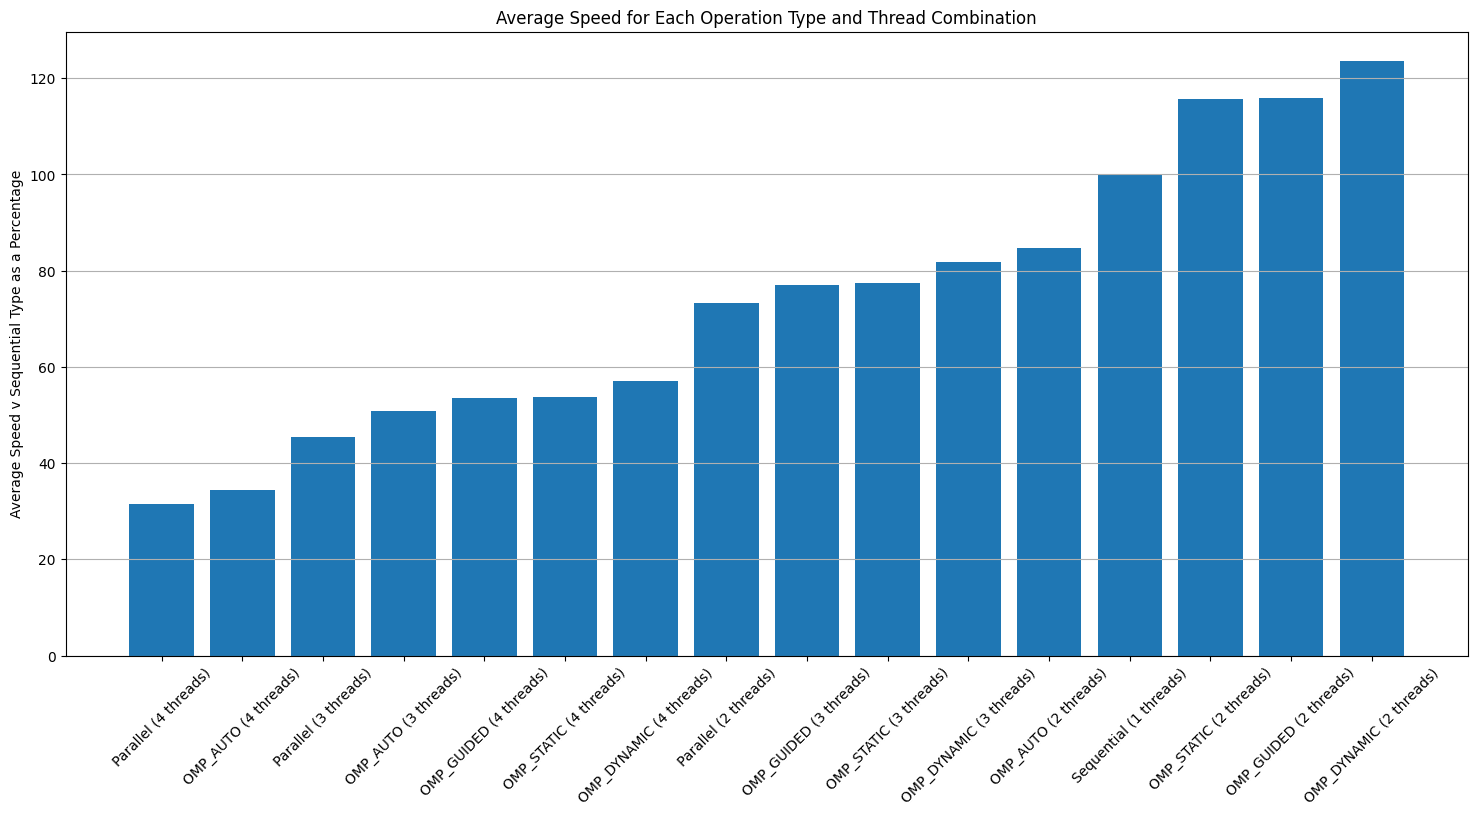

In [3]:
# Get the unique operation types and thread counts from the dataset.
operationTypes = data['type'].unique()
threadCounts = data['numThreads'].unique()

# Get the mean of the sequential time data.
averageSequentialTime = data[data['type'] == 'Sequential']['time'].mean()

# Calculating the Speedup
speedups = []

for operationType in operationTypes:
    for threadCount in threadCounts:
        # Filter for current operation type and thread count.
        subset = data[(data['type'] == operationType) & (data['numThreads'] == threadCount)]
        if not subset.empty:
            
            # Calculate average speed for each combination of types.
            avgSequentialTimeForSubset = data[(data['type'] == "Sequential") & (data['size'].isin(subset['size']))]['time'].mean()
            avgParallelTime = subset['time'].mean()
            avgSpeedup = (avgParallelTime / avgSequentialTimeForSubset) * 100
            
            speedups.append({
                "type": operationType,
                "numThreads": threadCount,
                "avgSpeedup": avgSpeedup
            })

# Convert the list of dictionaries to a DataFrame
compSpeedDF = pd.DataFrame(speedups)
# Set sequential to 100% as the above doesn't take this into account.
compSpeedDF.loc[compSpeedDF['type'] == 'Sequential', 'avgSpeedup'] = 100.0


plt.figure(figsize=(15, 7))

compSpeedDF = compSpeedDF.sort_values(by='avgSpeedup')  # Sort for the desired visualization

plt.bar(compSpeedDF['type'] + " (" + compSpeedDF['numThreads'].astype(str) + " threads)", compSpeedDF['avgSpeedup'])
plt.ylabel('Average Speed v Sequential Type as a Percentage')
plt.title('Average Speed for Each Operation Type and Thread Combination')
plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(axis='y')

# The below is save the image directly.
#plt.savefig('images/speed_barcharts.png', dpi=300, bbox_inches='tight')

plt.show()


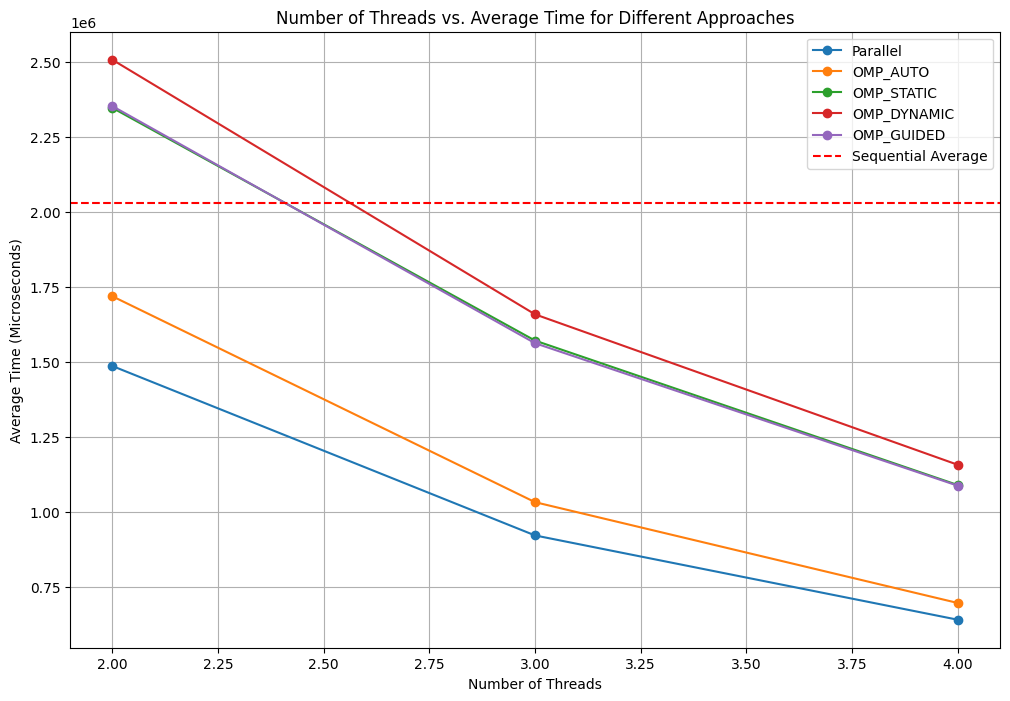

In [4]:
# Averaging the time for all sizes for each program type and thread number, excluding the sequential type
nonSequentialData = data[data['type'] != 'Sequential']
averageThreadTimesNonSeq = nonSequentialData.groupby(['type', 'numThreads'])['time'].mean().reset_index()

# Calculating the average time for the Sequential program type
averageSeqTime = data[data['type'] == 'Sequential']['time'].mean()

plt.figure(figsize=(12, 8))

# Iterating over each unique operation type (excluding Sequential) to plot their average times
for operationType in nonSequentialData['type'].unique():
    # Filtering the average times for the current operation type
    subset = averageThreadTimesNonSeq[averageThreadTimesNonSeq['type'] == operationType]
    
    # Plotting the average time for each number of threads for the current operation type
    plt.plot(subset['numThreads'], subset['time'], label=operationType, marker='o')

# Plotting the average time of the Sequential program type as a horizontal line for reference
plt.axhline(averageSeqTime, color='red', linestyle='--', label='Sequential Average')


plt.title('Number of Threads vs. Average Time for Different Approaches')
plt.xlabel('Number of Threads')
plt.ylabel('Average Time (Microseconds)')


plt.legend()
plt.grid(True)

# Uncomment the below line to save the figure as an image
#plt.savefig('images/time_by_threads_by_type_combined.png', dpi=300, bbox_inches='tight')

plt.show()

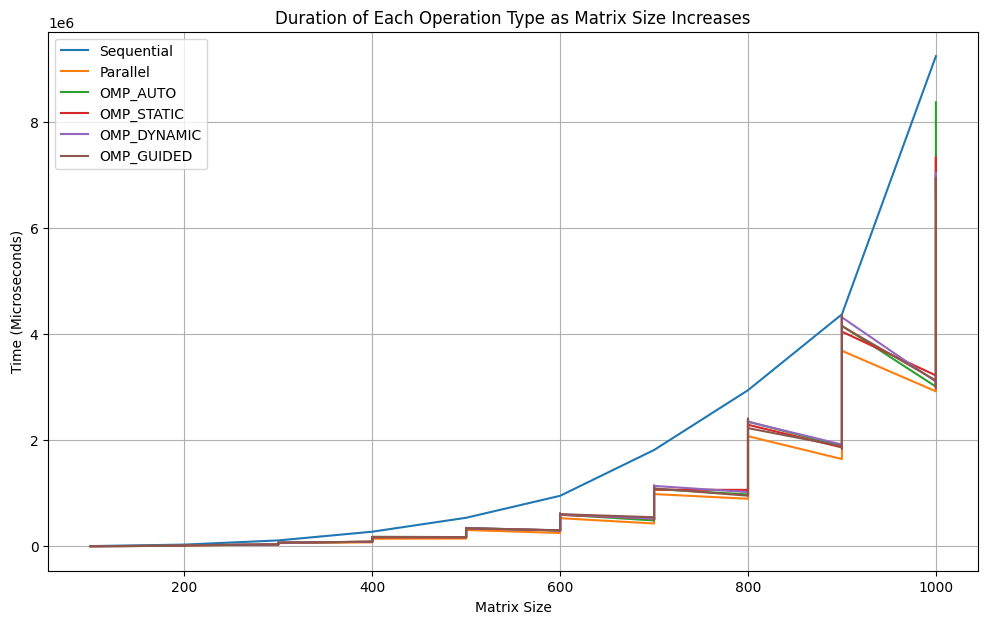

In [5]:
plt.figure(figsize=(12, 7))

# Iterate over each unique operation type to plot their times against matrix size
for operationTypes in data['type'].unique():
    # Filter the data for the current operation type
    subset = data[data['type'] == operationTypes]
    
    # Plot the time for the current operation type against matrix size
    plt.plot(subset['size'], subset['time'], label=operationTypes)

plt.title('Duration of Each Operation Type as Matrix Size Increases')
plt.xlabel('Matrix Size')
plt.ylabel('Time (Microseconds)')

plt.legend()
plt.grid(True)

# Uncomment the below line to save the figure as an image
#plt.savefig('images/time_by_size.png', dpi=300, bbox_inches='tight')

plt.show()

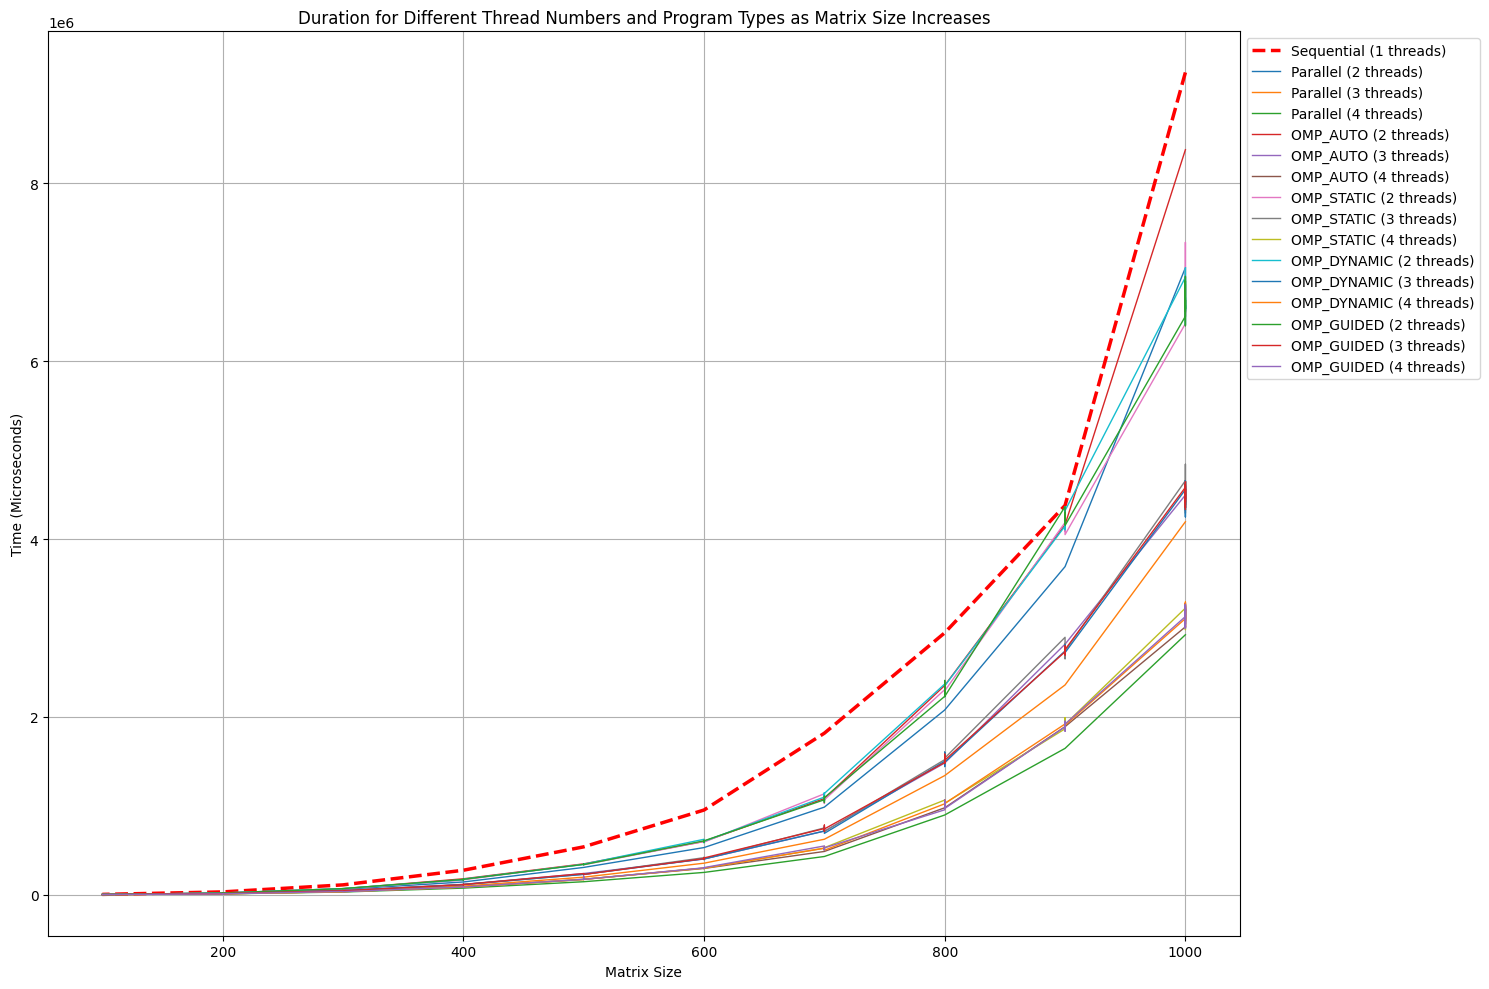

In [6]:
plt.figure(figsize=(15, 10))

# Extract unique operation types and thread counts from the data
operationTypes = data['type'].unique()
threadCounts = data['numThreads'].unique()

# Iterate over each unique operation type and thread count to plot their times against matrix size
for operationType in operationTypes:
    for threadCount in threadCounts:
        # Filter the data for the current operation type and thread count combination
        subset = data[(data['type'] == operationType) & (data['numThreads'] == threadCount)]
        
        if not subset.empty:

            label = f"{operationType} ({threadCount} threads)"
            linewidth = 2.5 if operationType == "Sequential" else 1
            color = "red" if operationType == "Sequential" else None
            linestyle = '--' if operationType == "Sequential" else None
            
            # Plot the time for the current combination against matrix size
            plt.plot(subset['size'], subset['time'], label=label, linewidth=linewidth, color=color, linestyle=linestyle)

plt.title('Duration for Different Thread Numbers and Program Types as Matrix Size Increases')
plt.xlabel('Matrix Size')
plt.ylabel('Time (Microseconds)')


plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()

# Uncomment the below line to save the figure as an image
#plt.savefig('images/time_by_size_by_type.png', dpi=300, bbox_inches='tight')

plt.show()

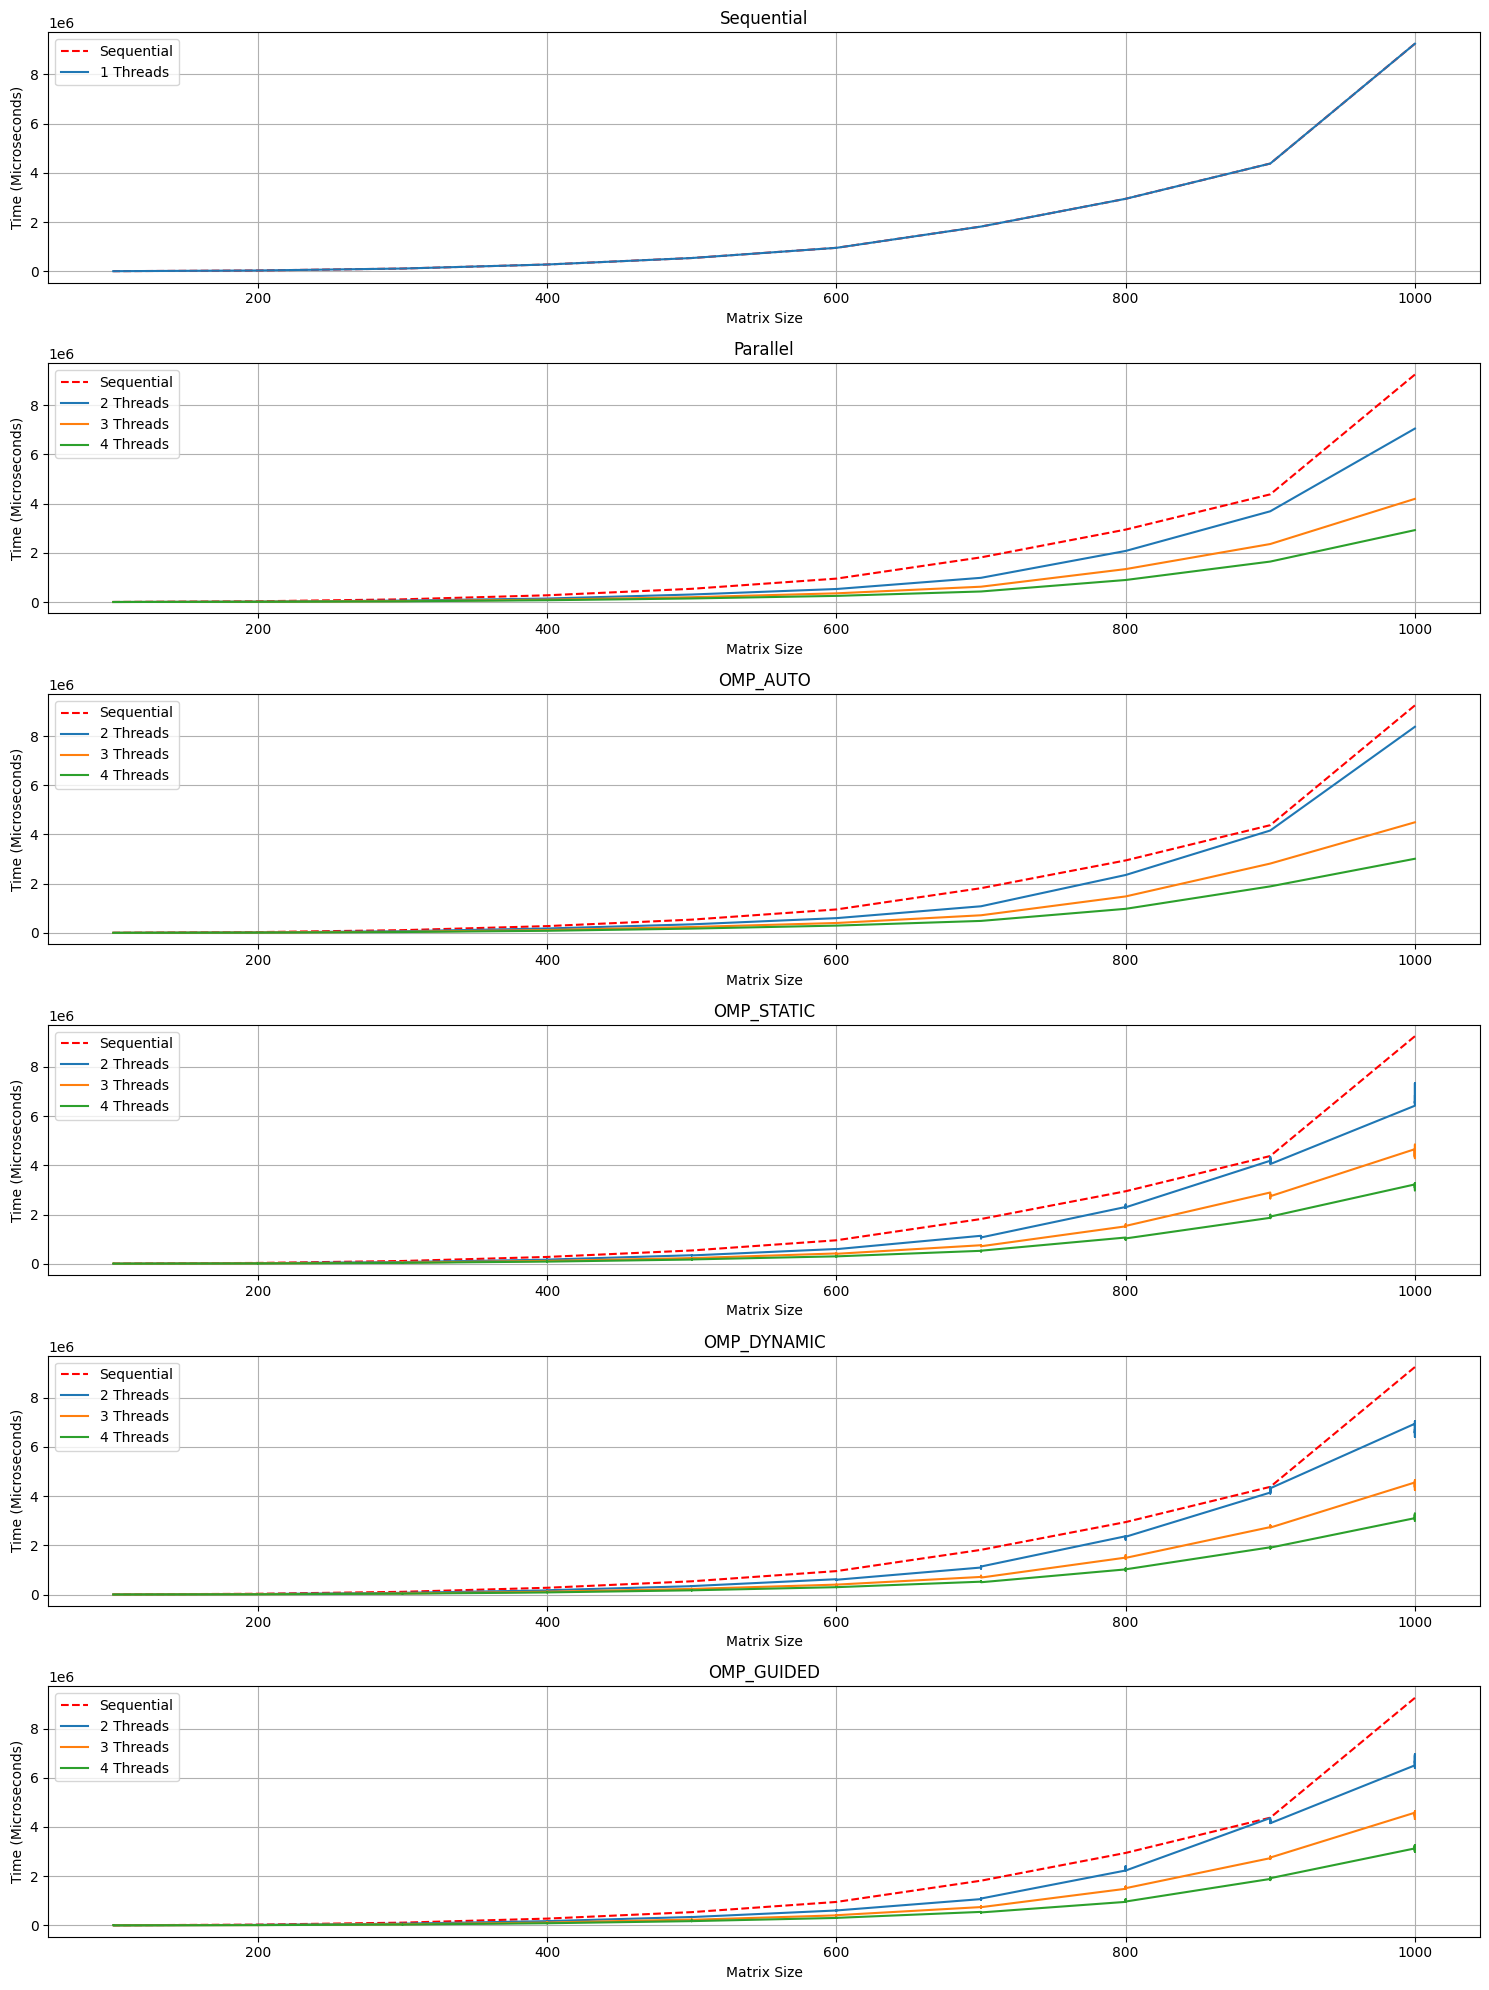

In [7]:
# Filtering the data to extract only the Sequential type
sequentialData = data[data['type'] == 'Sequential']


plt.figure(figsize=(15, 20))

# Create individual subplots for each unique operation type
for idx, operationType in enumerate(operationTypes, start=1):
    plt.subplot(len(operationTypes), 1, idx)
    
    # Plot the data of the Sequential type on every subplot as a reference for comparison
    plt.plot(sequentialData['size'], sequentialData['time'], label="Sequential", linestyle='--', color='red')
    
    # Filter the main dataset to get data of the current operation type
    subset = data[data['type'] == operationType]
    for thread in subset['numThreads'].unique():
        # Further filter the subset to get data for each unique thread count
        threadSubset = subset[subset['numThreads'] == thread]
        plt.plot(threadSubset['size'], threadSubset['time'], label=f"{thread} Threads")
    
    # Set title and axis labels for each subplot
    plt.title(operationType)
    plt.xlabel('Matrix Size')
    plt.ylabel('Time (Microseconds)')
    plt.legend()
    plt.grid(True)

# Adjust the layout to avoid overlap between subplots
plt.tight_layout()

# Uncomment the line below to save the plot as an image
#plt.savefig('images/size_by_time_by_threads.png', dpi=300, bbox_inches='tight')

plt.show()

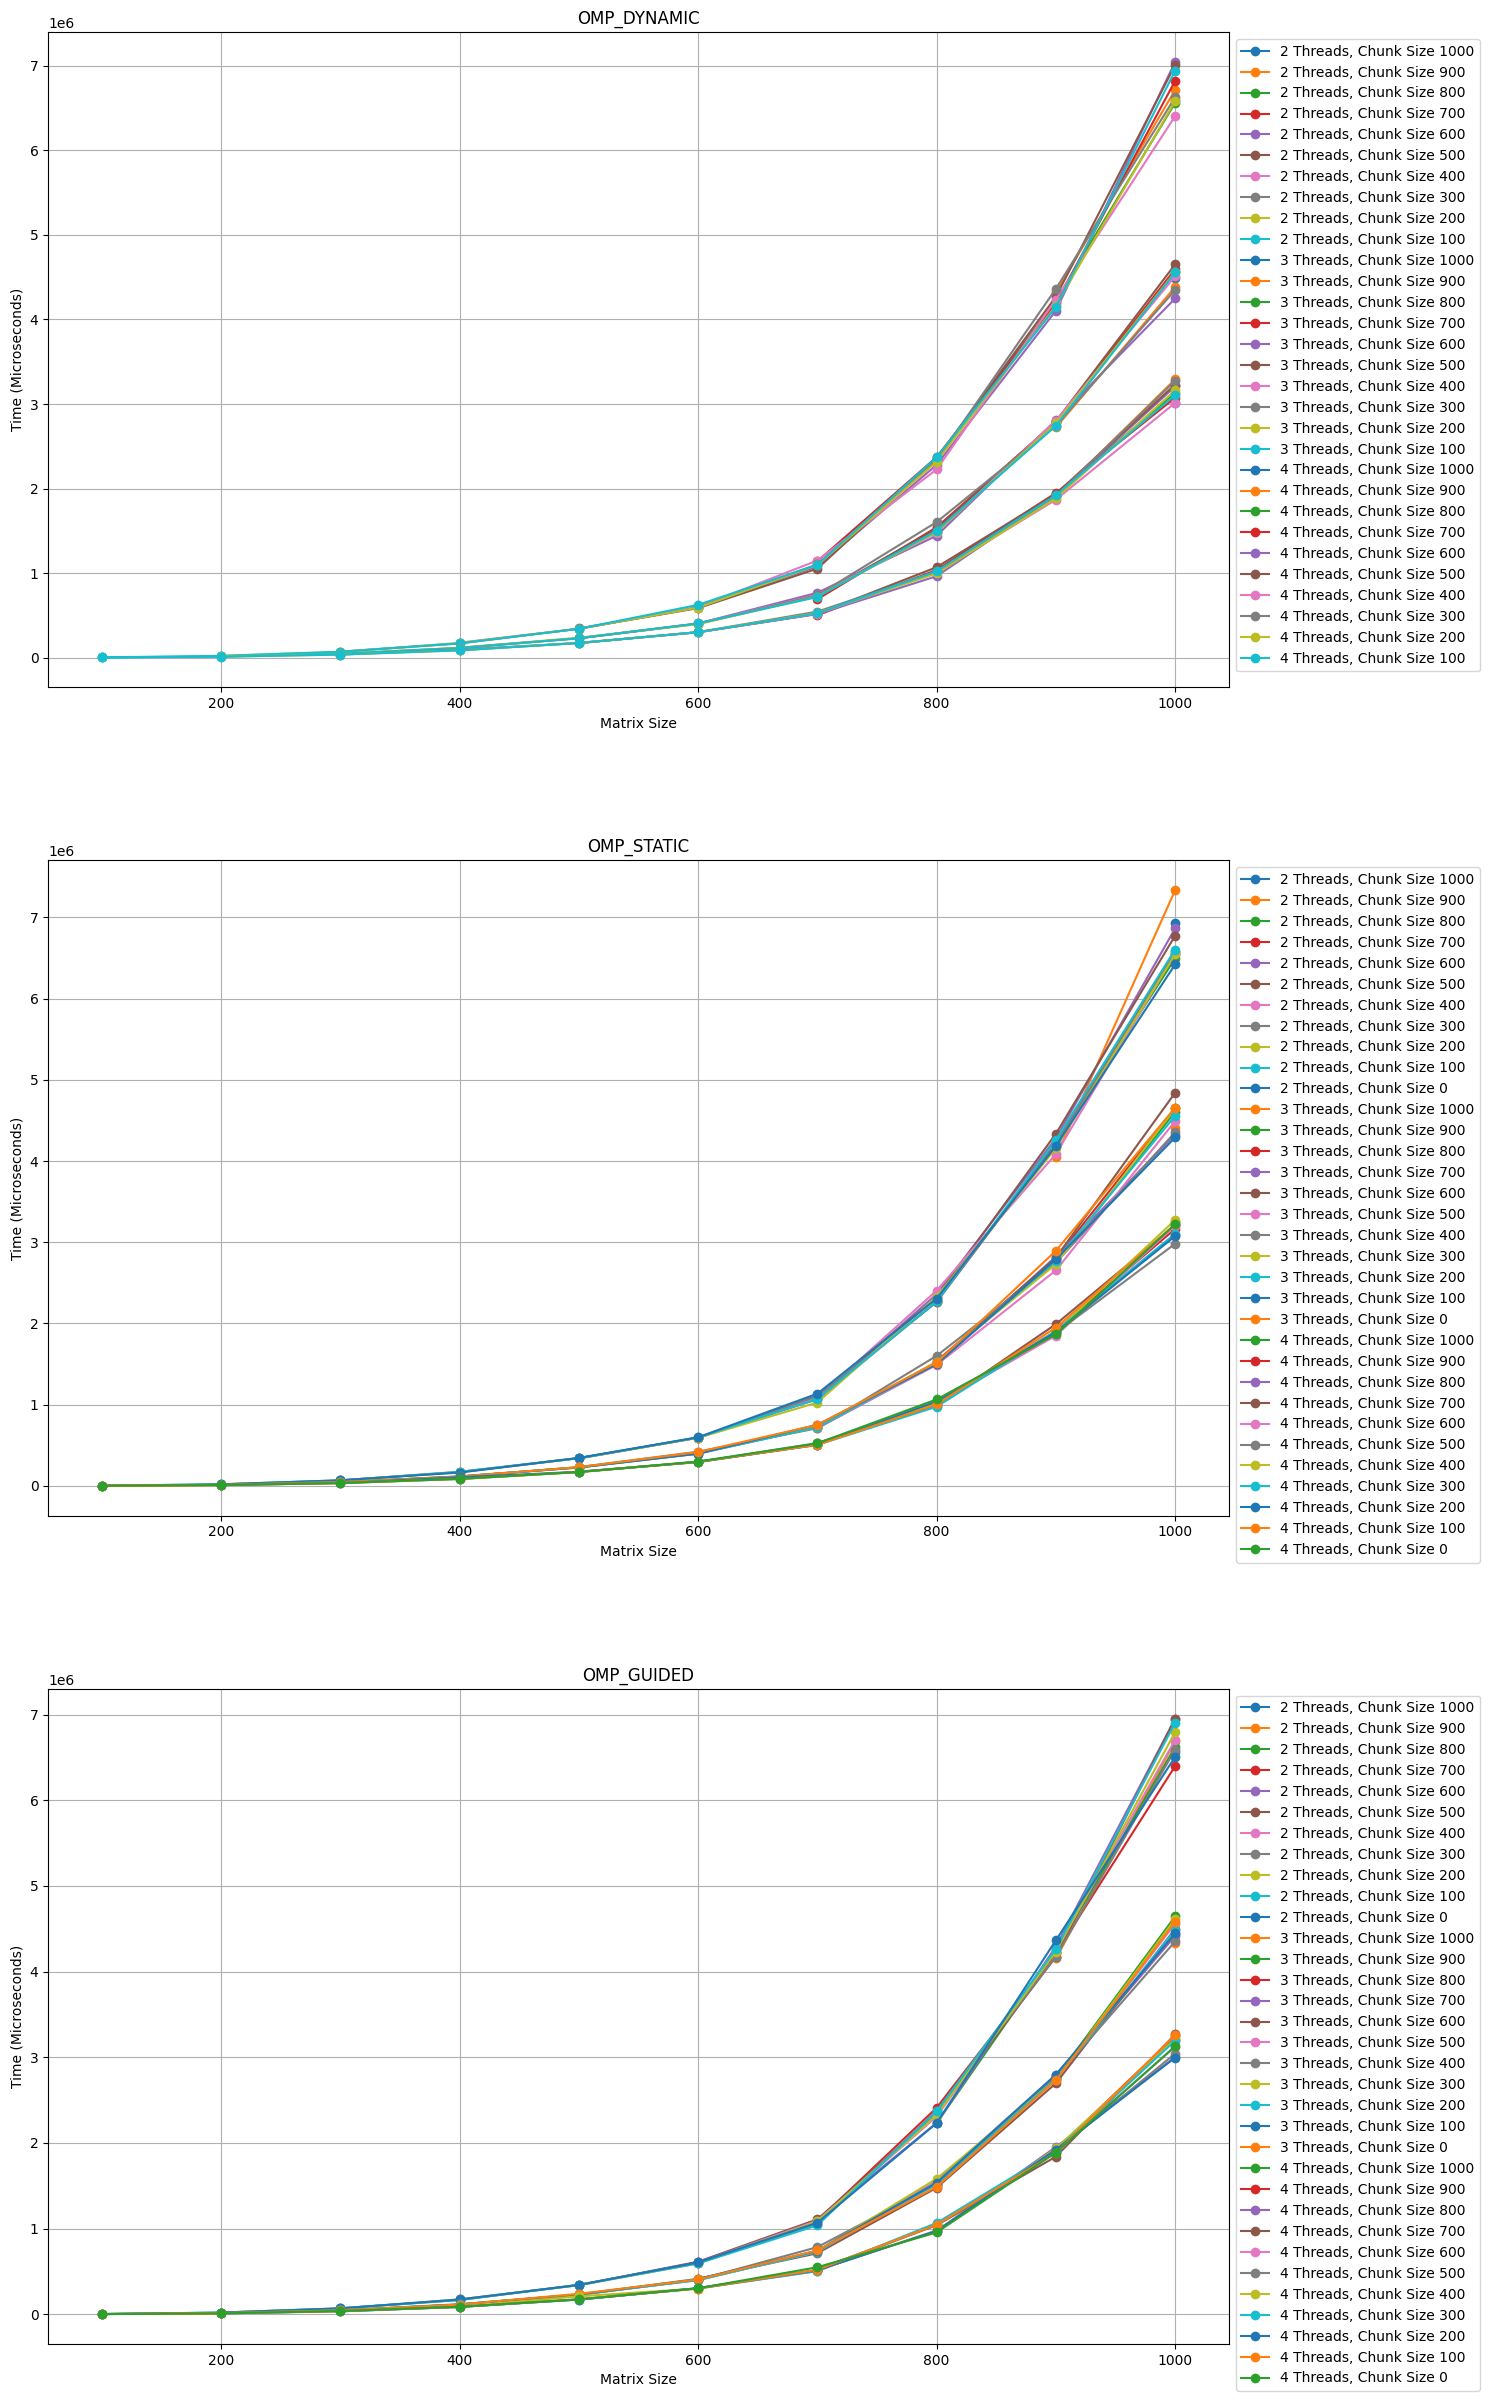

In [8]:
# Define chunk types to be visualized
chunkTypes = ['OMP_DYNAMIC', 'OMP_STATIC', 'OMP_GUIDED']

# Filter the main dataset to get only the data of the specified chunk types
chunkData = data[data['type'].isin(chunkTypes)]

# Group the chunkData by type, number of threads, and chunk size to get average time
average_time_by_chunk = chunkData.groupby(['type', 'numThreads', 'chunksize'])['time'].mean().reset_index()

# Set up a large figure to accommodate multiple subplots for each chunk type
plt.figure(figsize=(15, 25))

# Create individual subplots for each chunk type
for idx, operationType in enumerate(chunkTypes, start=1):
    plt.subplot(len(chunkTypes), 1, idx)
    
    # Filter the chunkData to get data for the current chunk type
    subset = chunkData[chunkData['type'] == operationType]
    for thread in subset['numThreads'].unique():
        # Further filter the subset to get data for each unique thread count
        threadSubset = subset[subset['numThreads'] == thread]
        for chunk in threadSubset['chunksize'].unique():
            # Further filter to get data for each unique chunk size under the current thread count
            chunkThreadSubset = threadSubset[threadSubset['chunksize'] == chunk]
            plt.plot(chunkThreadSubset['size'], chunkThreadSubset['time'], 
                     label=f"{thread} Threads, Chunk Size {chunk}", marker='o')
    
    # Set title and axis labels for each subplot
    plt.title(operationType)
    plt.xlabel('Matrix Size')
    plt.ylabel('Time (Microseconds)')
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.grid(True)

plt.tight_layout()

# Uncomment the line below to save the plot as an image
#plt.savefig('images/chunks_by_threads_combined_threads.png', dpi=300, bbox_inches='tight')

plt.show()